In [31]:
import warnings
warnings.filterwarnings('ignore')

import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from ucimlrepo import fetch_ucirepo
from copy import deepcopy
from scipy.stats import laplace
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import classification_report
from collections import Counter

In [2]:
!pip install ucimlrepo

## Przygotowanie danych

In [32]:
# Pobieranie danych
adult = fetch_ucirepo(id=2)
X = adult.data.features
y = adult.data.targets

In [33]:
# Przygotowanie danych - wybranie interesujących kolumn
df = pd.concat([X, y], axis=1)
selected_columns = ['age', 'education-num', 'hours-per-week', 'income']
df = df[selected_columns]
df["income"] = df["income"].str.strip().str.replace('.', '', regex=False)

# Podział na zbiory treningowy i testowy
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42, stratify=df['income'])
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.head(15)

,age,education-num,hours-per-week,income
0,17,8,30,<=50K
1,68,6,20,<=50K
2,36,9,40,<=50K
3,29,12,40,<=50K
4,47,13,40,<=50K
5,31,10,40,<=50K
6,51,9,40,<=50K
7,54,6,40,<=50K
8,35,9,5,<=50K
9,40,11,40,<=50K


In [34]:
# Liczność klas w zbiorze treningowym
print("Train set class distribution:")
print(train_df["income"].value_counts())

# Liczność klas w zbiorze testowym
print("\nTest set class distribution:")
print(test_df["income"].value_counts())

Train set class distribution:
income
<=50K    27866
>50K      8765
Name: count, dtype: int64

Test set class distribution:
income
<=50K    9289
>50K     2922
Name: count, dtype: int64


In [35]:
# Zapisanie tych liczności jako stałe na potem
len1 = 8765
len2 = 27866

In [36]:
# Sprawdzenie zakresu każdej z kolumn
summary = pd.DataFrame({
    'min': train_df.min(numeric_only=True),
    'max': train_df.max(numeric_only=True)
})
print(summary)

                min  max
age              17   90
education-num     1   16
hours-per-week    1   99


In [37]:
# Ustalenie epsilona - poziomu prywatności
epsilon = 0.1

# Ustalenie m - rozmiaru bazy wyjściowej
m1 = 9000
m2 = 27000

In [55]:
# Stworzenie przestrzeni wyników (osobnej dla każdej klasy docelowej)
space = []
space2 = []
for i in range(17, 91):
    plane = []
    plane2 = []
    for j in range(1, 17):
        line = []
        line2 = []
        for k in range(1, 100):
            line.append(0)
            line2.append(0)
        plane.append(line)
        plane2.append(line2)
    space.append(plane)
    space2.append(plane2)

for row in train_df.itertuples():
    if row[4] == ">50K":
        space[row[1] - 17][row[2] - 1][row[3] - 1] += 1/len1
    else:
        space2[row[1] - 17][row[2] - 1][row[3] - 1] += 1/len2

## Mechanizm Laplace'a

In [56]:
# Mechanizm Laplace'a - mówi on o tym, że do każdego elementu przestrzeni wyników dodajemy
# niezależną (od pozostałych) zmienną losową z rozkładu Laplace'a z parametrem skali równym 2/(epsilon * wielkość zbioru)

space_lm = deepcopy(space)
space2_lm = deepcopy(space2)
L1 = laplace.rvs(loc=0, scale=2/(epsilon*len1), size=2**17)
L2 = laplace.rvs(loc=0, scale=2/(epsilon*len2), size=2**17)

counter = 0
for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            space_lm[i - 17][j - 1][k - 1] += L1[counter]
            space2_lm[i - 17][j - 1][k - 1] += L2[counter]
            counter += 1

In [57]:
# Sprawdzenie miary całej Omegi w obu przypadkach - nie chcemy aby była ujemna
total_val = 0
for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            total_val += space_lm[i - 17][j - 1][k - 1]
print(total_val)

total_val2 = 0
for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            total_val2 += space2_lm[i - 17][j - 1][k - 1]
print(total_val2)

assert total_val >= 0
assert total_val2 >= 0

2.4537281534107285
0.5097527181616245


In [58]:
# Zamiana miary znakowej na nieznakową - podejście heurystyczne

directions = [[1, 0, 0], [-1, 0, 0], [0, 1, 0], [0, -1, 0], [0, 0, 1], [0, 0, -1]]

for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            val = space_lm[i - 17][j - 1][k - 1]
            if val < 0:
                val *= -1
                space_lm[i - 17][j - 1][k - 1] = 0
                counter = 1
                while val > 0.01 and counter != 0:
                    counter = 0
                    val_counter = 0
                    for [di, dj, dk] in directions:
                        if 0 <= i - 17 + di < 91 - 17 and 0 <= j - 1 + dj < 17 - 1 and 0 <= k - 1 + dk < 100 - 1:
                            if space_lm[i - 17 + di][j - 1 + dj][k - 1 + dk] > val/100:
                                counter += 1
                                val_counter += val/100
                                space_lm[i - 17 + di][j - 1 + dj][k - 1 + dk] -= val/100
                    val -= val_counter

for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            val = space2_lm[i - 17][j - 1][k - 1]
            if val < 0:
                val *= -1
                space2_lm[i - 17][j - 1][k - 1] = 0
                counter = 1
                while val > 0.01 and counter != 0:
                    counter = 0
                    val_counter = 0
                    for [di, dj, dk] in directions:
                        if 0 <= i - 17 + di < 91 - 17 and 0 <= j - 1 + dj < 17 - 1 and 0 <= k - 1 + dk < 100 - 1:
                            if space2_lm[i - 17 + di][j - 1 + dj][k - 1 + dk] > val/100:
                                counter += 1
                                val_counter += val/100
                                space2_lm[i - 17 + di][j - 1 + dj][k - 1 + dk] -= val/100
                    val -= val_counter


for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            assert space_lm[i - 17][j - 1][k - 1] >= 0
            assert space2_lm[i - 17][j - 1][k - 1] >= 0

In [59]:
# Ponowne sprawdzenie miary Omegi - zweryfikowanie błedu podejścia heurystycznego
total_val = 0
for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            total_val += space_lm[i - 17][j - 1][k - 1]
print(total_val)

total_val2 = 0
for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            total_val2 += space2_lm[i - 17][j - 1][k - 1]
print(total_val2)

133.27211772455223
42.52319334871674


In [60]:
# zamiana miary nieznakowej na miarę empiryczną (kodującą m elementów)
total_space_lm = 0
total_space2_lm = 0

for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            space_lm[i - 17][j - 1][k - 1] = math.floor(m1 * space_lm[i - 17][j - 1][k - 1] / total_val)
            total_space_lm += space_lm[i - 17][j - 1][k - 1]
            space2_lm[i - 17][j - 1][k - 1] = math.floor(m2 * space2_lm[i - 17][j - 1][k - 1] / total_val2)
            total_space2_lm += space2_lm[i - 17][j - 1][k - 1]

assert total_space_lm <= m1
assert total_space2_lm <= m2

while total_space_lm < m1:
    di = random.randint(17, 90)
    dj = random.randint(1, 16)
    dk = random.randint(1, 99)
    space_lm[di - 17][dj - 1][dk - 1] += 1
    total_space_lm += 1

while total_space2_lm < m2:
    di = random.randint(17, 90)
    dj = random.randint(1, 16)
    dk = random.randint(1, 99)
    space2_lm[di - 17][dj - 1][dk - 1] += 1
    total_space2_lm += 1

In [61]:
# Powrót z miary do bazy danych
rows = []

for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            rows.extend([[i, j, k, ">50K"]] * space_lm[i - 17][j - 1][k - 1])
            rows.extend([[i, j, k, "<=50K"]] * space2_lm[i - 17][j - 1][k - 1])

train_df_lm = pd.DataFrame(rows, columns=["age", "education-num", "hours-per-week", "income"])

print(train_df_lm.head())
assert len(train_df_lm) == m1 + m2

   age  education-num  hours-per-week income
0   17              1               9  <=50K
1   17              1               9  <=50K
2   17              1              12  <=50K
3   17              1              16  <=50K
4   17              1              18   >50K


## Algorytm wykorzystujący SSL


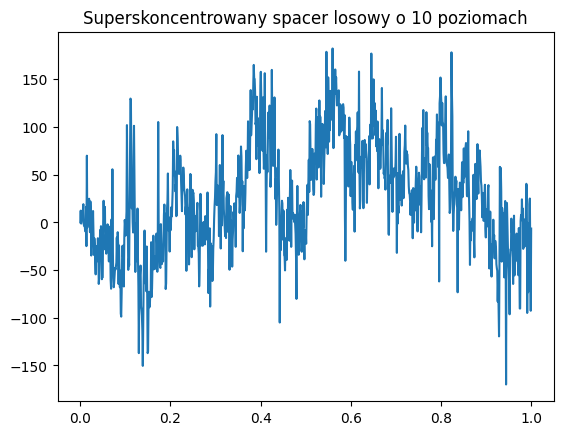

In [62]:
# Funkcja generująca 2 ^ levels zmiennych losowych reprezentujących kolejne kroki SSL
def superregular_walk(levels, show_plot=False):

    # Funkcja czapkowa z "czapką" na przedziale (left, right).
    def hat_fun(x, left, right):
        mid = (left + right) / 2
        return max(0, 1 - abs(x - mid)/(mid - left))

    # Generowanie wszystkich "czapkowych" przedziałów dla levels pierwszych poziomów.
    current = 0
    ints = [[0, 2]]
    while current < levels:
        left = 0
        step = 1 / 2 ** current
        right = step
        while left < 1:
            ints.append([left, right])
            left += step
            right += step
        current += 1

    # Generowanie zmiennych losowych i obliczenie kolejnych wartości SRW
    X = np.linspace(0, 1, 2 ** levels + 1)
    L = np.random.laplace(0, 2 * levels + 1, 2 ** levels)
    Y = [0]
    for i in range(len(X) - 1):
        val = 0
        for j in range(levels + 1):
            if j == 0: k = 0
            else: k = 2 ** (j - 1) + i // 2 ** (levels + 1 - j)
            val += hat_fun(X[i+1], ints[k][0], ints[k][1]) * L[k]
        Y.append(float(val))

    # Opcjonalne pokazanie wykresu
    if show_plot:
        plt.plot(X, Y)
        plt.title(f"Superskoncentrowany spacer losowy o {levels} poziomach")
        plt.show()

    L = []
    for i in range(len(Y) - 1):
        L.append(Y[i + 1] - Y[i])
    return L


_ = superregular_walk(10, True)

In [85]:
# Zaburzenie przestrzeni wyników za pomocą SSL

space_srw = deepcopy(space)
space2_srw = deepcopy(space2)
levels = 17 # 2^17 - tyle musimy wygenerować zmiennych, aby wystarczyło na całą przestrzeń
L1 = superregular_walk(levels, False)
L2 = superregular_walk(levels, False)
counter = 0

for j in range(1, 17): # zamiana kolejności iteracji - intuicja w pracy
    if j % 2 == 0:
        for i in range(17, 91):
            if i % 2 == 0:
                for k in range(1, 100):
                    space_srw[i - 17][j - 1][k - 1] += L1[counter] * 2/(epsilon * len1)
                    space2_srw[i - 17][j - 1][k - 1] += L2[counter] * 2/(epsilon * len2)
                    counter += 1
            else:
                for k in range(99, 0, -1):
                    space_srw[i - 17][j - 1][k - 1] += L1[counter] * 2/(epsilon * len1)
                    space2_srw[i - 17][j - 1][k - 1] += L2[counter] * 2/(epsilon * len2)
                    counter += 1
    else:
        for i in range(90, 16, -1):
            if i % 2 == 0:
                for k in range(1, 100):
                    space_srw[i - 17][j - 1][k - 1] += L1[counter] * 2/(epsilon * len1)
                    space2_srw[i - 17][j - 1][k - 1] += L2[counter] * 2/(epsilon * len2)
                    counter += 1
            else:
                for k in range(99, 0, -1):
                    space_srw[i - 17][j - 1][k - 1] += L1[counter] * 2/(epsilon * len1)
                    space2_srw[i - 17][j - 1][k - 1] += L2[counter] * 2/(epsilon * len2)
                    counter += 1

In [86]:
# Sprawdzenie miary całej Omegi w obu przypadkach - nie chcemy aby była ujemna
total_val = 0
for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            total_val += space_srw[i - 17][j - 1][k - 1]
print(total_val)

total_val2 = 0
for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            total_val2 += space2_srw[i - 17][j - 1][k - 1]
print(total_val2)

assert total_val >= 0
assert total_val2 >= 0

1.021900541658923
0.9844502118640461


In [87]:
# Zamiana miary znakowej na nieznakową - podejście heurystyczne

directions = [[1, 0, 0], [-1, 0, 0], [0, 1, 0], [0, -1, 0], [0, 0, 1], [0, 0, -1]]

for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            val = space_srw[i - 17][j - 1][k - 1]
            if val < 0:
                val *= -1
                space_srw[i - 17][j - 1][k - 1] = 0
                counter = 1
                while val > 0.01 and counter != 0:
                    counter = 0
                    val_counter = 0
                    for [di, dj, dk] in directions:
                        if 0 <= i - 17 + di < 91 - 17 and 0 <= j - 1 + dj < 17 - 1 and 0 <= k - 1 + dk < 100 - 1:
                            if space_srw[i - 17 + di][j - 1 + dj][k - 1 + dk] > val/100:
                                counter += 1
                                val_counter += val/100
                                space_srw[i - 17 + di][j - 1 + dj][k - 1 + dk] -= val/100
                    val -= val_counter

for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            val = space2_srw[i - 17][j - 1][k - 1]
            if val < 0:
                val *= -1
                space2_srw[i - 17][j - 1][k - 1] = 0
                counter = 1
                while val > 0.01 and counter != 0:
                    counter = 0
                    val_counter = 0
                    for [di, dj, dk] in directions:
                        if 0 <= i - 17 + di < 91 - 17 and 0 <= j - 1 + dj < 17 - 1 and 0 <= k - 1 + dk < 100 - 1:
                            if space2_srw[i - 17 + di][j - 1 + dj][k - 1 + dk] > val/100:
                                counter += 1
                                val_counter += val/100
                                space2_srw[i - 17 + di][j - 1 + dj][k - 1 + dk] -= val/100
                    val -= val_counter


for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            assert space_srw[i - 17][j - 1][k - 1] >= 0
            assert space2_srw[i - 17][j - 1][k - 1] >= 0

In [88]:
# Ponowne sprawdzenie miary Omegi - zweryfikowanie błedu podejścia heurystycznego
total_val = 0
for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            total_val += space_srw[i - 17][j - 1][k - 1]
print(total_val)

total_val2 = 0
for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            total_val2 += space2_srw[i - 17][j - 1][k - 1]
print(total_val2)

1471.6234555206424
676.5706292081468


In [89]:
# zamiana miary nieznakowej na miarę empiryczną (kodującą m elementów)
total_space_srw = 0
total_space2_srw = 0

for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            space_srw[i - 17][j - 1][k - 1] = math.floor(m1 * space_srw[i - 17][j - 1][k - 1] / total_val)
            total_space_srw += space_srw[i - 17][j - 1][k - 1]
            space2_srw[i - 17][j - 1][k - 1] = math.floor(m2 * space2_srw[i - 17][j - 1][k - 1] / total_val2)
            total_space2_srw += space2_srw[i - 17][j - 1][k - 1]

assert total_space_srw <= m1
assert total_space2_srw <= m2

while total_space_srw < m1:
    di = random.randint(17, 90)
    dj = random.randint(1, 16)
    dk = random.randint(1, 99)
    space_srw[di - 17][dj - 1][dk - 1] += 1
    total_space_srw += 1

while total_space2_srw < m2:
    di = random.randint(17, 90)
    dj = random.randint(1, 16)
    dk = random.randint(1, 99)
    space2_srw[di - 17][dj - 1][dk - 1] += 1
    total_space2_srw += 1

In [90]:
# Powrót z miary do bazy danych
rows = []

for i in range(17, 91):
    for j in range(1, 17):
        for k in range(1, 100):
            rows.extend([[i, j, k, ">50K"]] * space_srw[i - 17][j - 1][k - 1])
            rows.extend([[i, j, k, "<=50K"]] * space2_srw[i - 17][j - 1][k - 1])

train_df_srw = pd.DataFrame(rows, columns=["age", "education-num", "hours-per-week", "income"])

print(train_df_srw.head())

assert len(train_df_srw) == m1 + m2

   age  education-num  hours-per-week income
0   17              1               7  <=50K
1   17              1              15   >50K
2   17              1              19   >50K
3   17              1              20   >50K
4   17              1              21  <=50K


## Test jakości otzrymanych baz danych

In [70]:
# Zmodyfikowany klasyfikator KNN przystosowany do niezbalansowanego datasetu
class PriorWeightedKNN:
    def __init__(self, n_neighbors=5):
        self.k = n_neighbors
        self.X_train = None
        self.y_train = None
        self.class_weights = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        self.X_train = X.values
        self.y_train = y.values

        class_counts = Counter(self.y_train)
        total = sum(class_counts.values())
        self.class_weights = {
            cls: total / (len(class_counts) * count)
            for cls, count in class_counts.items()
        }

    def predict(self, X: pd.DataFrame):
        X_test = X.values
        distances = euclidean_distances(X_test, self.X_train)
        preds = []

        for d in distances:
            idx = np.argsort(d)[:self.k]
            neighbor_labels = self.y_train[idx]
            neighbor_dists = d[idx]
            neighbor_weights = 1 / (neighbor_dists + 1e-8)

            class_vote_weights = {}
            for label, dist_weight in zip(neighbor_labels, neighbor_weights):
                weight = dist_weight * self.class_weights.get(label, 1.0)
                class_vote_weights[label] = class_vote_weights.get(label, 0.0) + weight

            preds.append(max(class_vote_weights, key=class_vote_weights.get))

        return np.array(preds)

In [72]:
# Test na oryginalnym (nie zaburzonym) zbiorze danych

X_train = train_df.drop(columns='income')
y_train = train_df['income']

X_test = test_df.drop(columns='income')
y_test = test_df['income']

knn = PriorWeightedKNN(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.86      0.74      0.80      9289
        >50K       0.43      0.63      0.51      2922

    accuracy                           0.72     12211
   macro avg       0.65      0.69      0.66     12211
weighted avg       0.76      0.72      0.73     12211



In [73]:
# Test na zbiorze danych po mechanizmie Laplace'a

X_train = train_df_lm.drop(columns='income')
y_train = train_df_lm['income']

X_test = test_df.drop(columns='income')
y_test = test_df['income']

knn = PriorWeightedKNN(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.77      0.74      0.76      9289
        >50K       0.27      0.31      0.29      2922

    accuracy                           0.64     12211
   macro avg       0.52      0.53      0.52     12211
weighted avg       0.65      0.64      0.64     12211



In [91]:
# Test na zbiorze danych po SRW

X_train = train_df_srw.drop(columns='income')
y_train = train_df_srw['income']

X_test = test_df.drop(columns='income')
y_test = test_df['income']

knn = PriorWeightedKNN(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.77      0.64      0.70      9289
        >50K       0.25      0.38      0.30      2922

    accuracy                           0.58     12211
   macro avg       0.51      0.51      0.50     12211
weighted avg       0.64      0.58      0.60     12211

